# OPAL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 2 Jun 2023

### Import OPAL framework and required classes

In [1]:
import sys
sys.path.append('../')
from opal import Linac, SourceBasic, StageNonlinear1D, InterstageELEGANT
import numpy as np

### Define the linac elements

In [2]:
# define driver
driver = SourceBasic()
driver.Q = -5e-9 # [C]
driver.E0 = 10e9 # [eV]
driver.relsigE = 0.01
driver.sigz = 20e-6 # [m]
driver.z = 120e-6 # [m]
driver.emitnx, driver.emitny = 10e-6, 10e-6 # [m rad]
driver.betax, driver.betay = 30e-3, 30e-3 # [m]
driver.Npart = 5000

# define stage
stage = StageNonlinear1D()
stage.driverSource = driver
stage.deltaE = 5.5e9 # [eV]
stage.L = 1 # [m]
stage.n0 = 2e22 # [m^-3]
stage.rampBetaMagnification = 10

# define beam
source = SourceBasic()
source.Q = -2.7e-9 # [C]
source.E0 = 3e9 # [eV]
source.relsigE = 0.005
source.sigz = 12e-6 # [m]
source.z = -60e-6 # [m]
source.emitnx = 10e-6 # [m rad]
source.emitny = 0.035e-6 # [m rad]
source.betax = stage.matchedBetaFunction(source.E0)
source.betay = source.betax
source.Npart = 1000

# define interstage (of energy-dependent length)
interstage = InterstageELEGANT()
interstage.beta0 = lambda E: stage.matchedBetaFunction(E)
interstage.Ldip = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.Bdip = 0.5 # [T]

# define linac
linac = Linac(source, stage, interstage, Nstages = 5)

### Perform linac tracking

In [3]:
# perform tracking run (3 shots)
linac.run("linac_example", shots = 3, overwrite = True);

>> SHOT #1
Tracking element #1 (s = 0.0 m, -2.70 nC, 3.0 GeV, SourceBasic, stage 0)
Tracking element #2 (s = 1.0 m, -2.70 nC, 8.7 GeV, StageNonlinear1D, stage 1)
Tracking element #3 (s = 5.4 m, -2.70 nC, 8.7 GeV, InterstageELEGANT, stage 1)
Tracking element #4 (s = 6.4 m, -2.70 nC, 14.1 GeV, StageNonlinear1D, stage 2)
Tracking element #5 (s = 11.9 m, -2.70 nC, 14.1 GeV, InterstageELEGANT, stage 2)
Tracking element #6 (s = 12.9 m, -2.70 nC, 19.4 GeV, StageNonlinear1D, stage 3)
Tracking element #7 (s = 19.5 m, -2.70 nC, 19.4 GeV, InterstageELEGANT, stage 3)
Tracking element #8 (s = 20.5 m, -2.70 nC, 24.8 GeV, StageNonlinear1D, stage 4)
Tracking element #9 (s = 28.0 m, -2.70 nC, 24.8 GeV, InterstageELEGANT, stage 4)
Tracking element #10 (s = 29.0 m, -2.70 nC, 30.2 GeV, StageNonlinear1D, stage 5)
>> SHOT #2
Tracking element #1 (s = 0.0 m, -2.70 nC, 3.0 GeV, SourceBasic, stage 0)
Tracking element #2 (s = 1.0 m, -2.70 nC, 8.7 GeV, StageNonlinear1D, stage 1)
Tracking element #3 (s = 5.4 m, -2

### Plot the wakefield

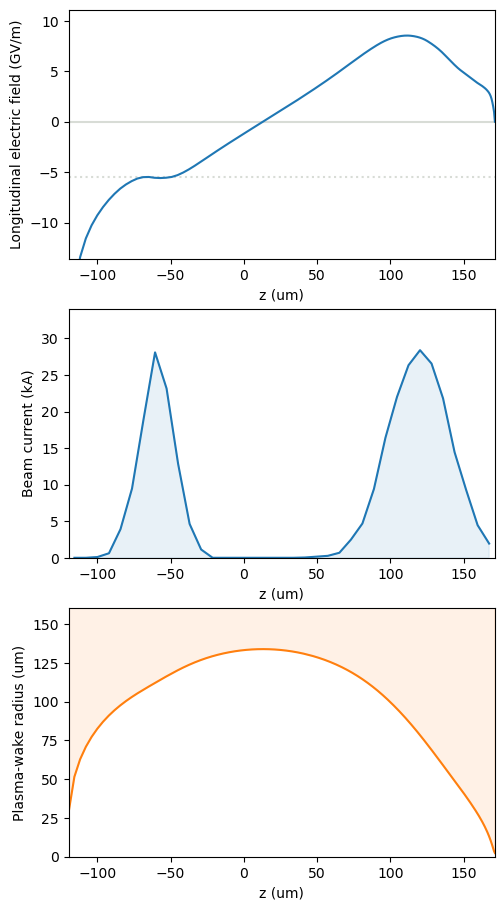

In [4]:
# plot wakefield
stage.plotWakefield(linac.initialBeam())

### Plot beam evolution and survey

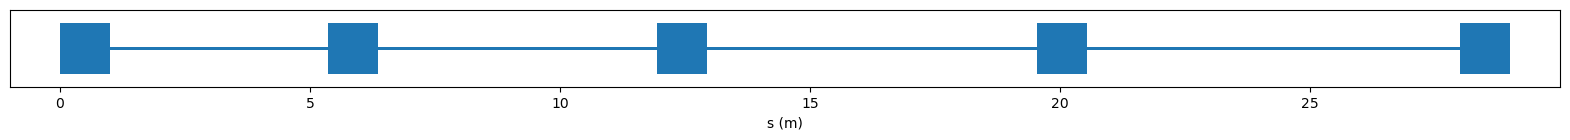

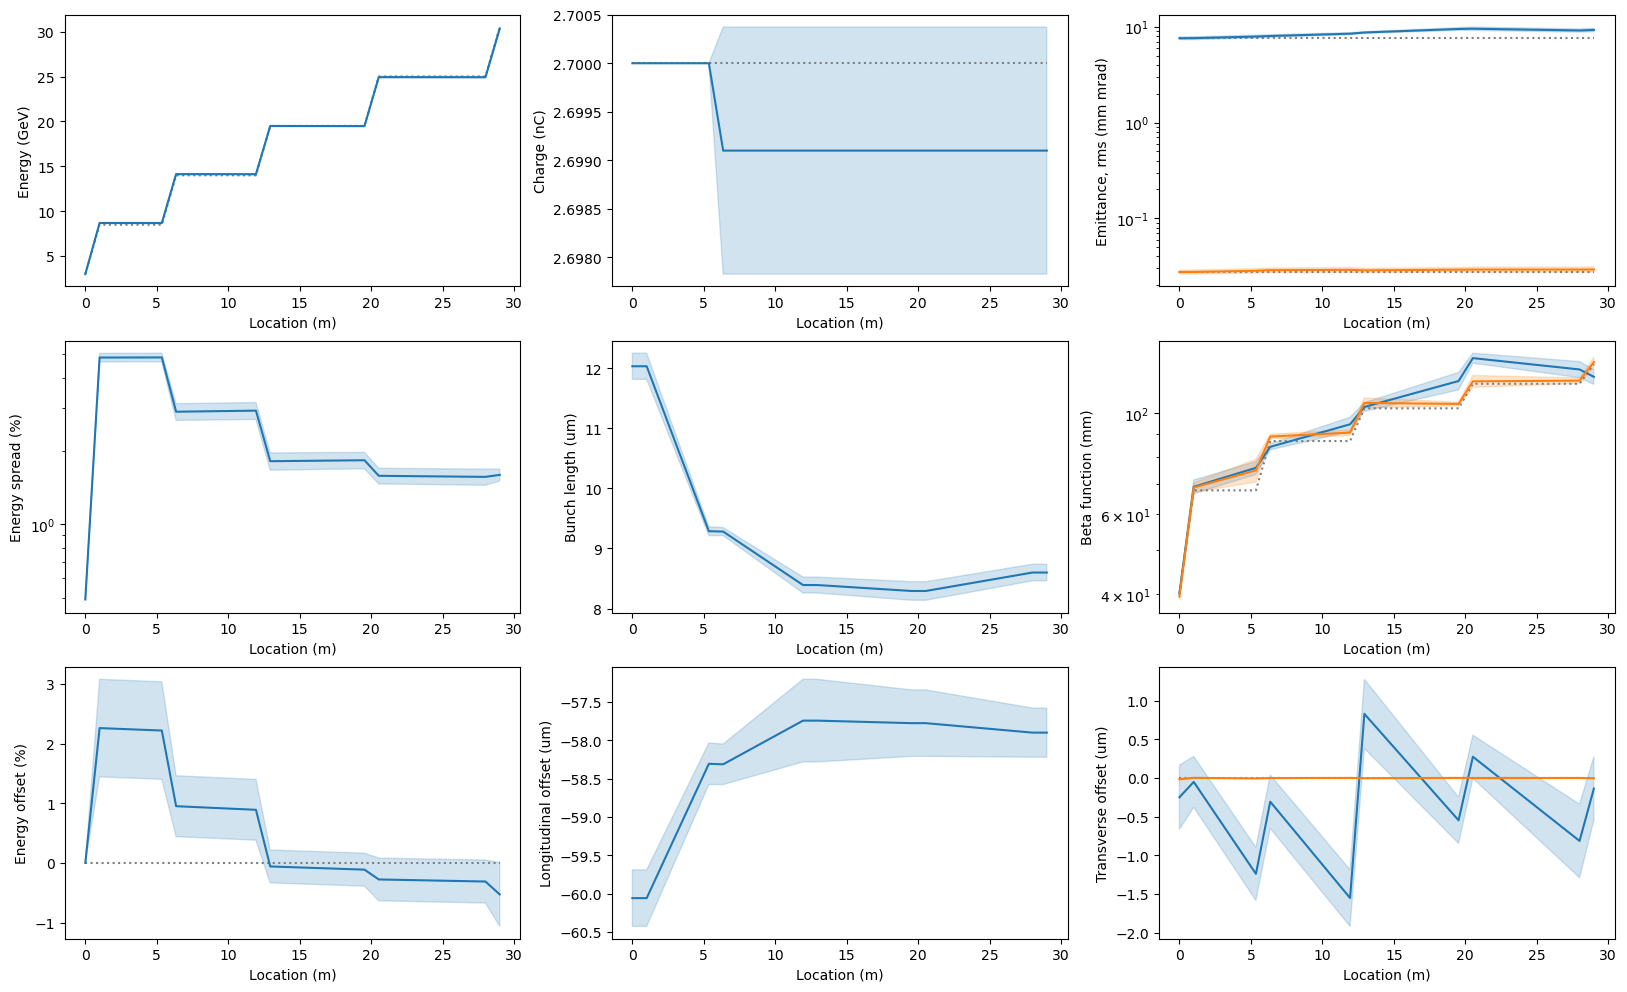

In [5]:
# plot linac survey
linac.plotSurvey()

# plot beam evolution
linac.plotEvolution()